# Using Knowledge Graph with Neo4jGraphStore


In [ ]:
!pip install llama-index-llms-openai llama-index-graph-stores-neo4j llama-index-embeddings-openai llama-index-llms-azure-openai llama-index-readers-file neo4j llama-index-readers-s3

In [ ]:
from llama_index.core import KnowledgeGraphIndex, SimpleDirectoryReader
from llama_index.core import StorageContext
from llama_index.graph_stores.neo4j import Neo4jGraphStore
import logging
import sys
from llama_index.llms.openai import OpenAI
from llama_index.core import Settings
from llama_index.llms.openai import OpenAI
from IPython.display import Markdown, display
import os
from llama_index.readers.s3 import S3Reader
import time
from google.colab import userdata

In [ ]:
key = userdata.get('openai')
password = userdata.get('password')
url = userdata.get('url')
aws_access_id = userdata.get('aws_access_id')
aws_access_secret = userdata.get('aws_secret')

## Configurando LLM

In [ ]:
os.environ["OPENAI_API_KEY"] = key

logging.basicConfig(stream=sys.stdout, level=logging.INFO)

# define LLM
llm = OpenAI(temperature=0, model="gpt-4o-mini")
Settings.llm = llm
Settings.chunk_size = 512

## Carregando documentos

In [ ]:
inicio = time.time()

loader = S3Reader(
    bucket='macall-dados-pcrj',
    prefix='documentos/',
    aws_access_id=aws_access_id,
    aws_access_secret=aws_access_secret,
)
documents = loader.load_data()

fim = time.time()

tempo_decorrido = fim - inicio

In [ ]:
print(f"Tempo para indexação de {len(documents)} documentos: {tempo_decorrido/60:.2f} minutos")

Tempo para indexação de 1270 documentos: 1.31 minutos


In [ ]:
# Você pode usar o código abaixo caso queira carregar documentos localmente
"""documents = SimpleDirectoryReader(
    "./texto"
).load_data()"""

## Indexando documentos no Neo4j

In [ ]:
# Credenciais de Acesso ao banco de dados de grafos Neo4j
username = "neo4j"
password = password
url = url
database = "neo4j"

In [ ]:
graph_store = Neo4jGraphStore(
    username=username,
    password=password,
    url=url,
    database=database,
)

In [ ]:
inicio = time.time()

storage_context = StorageContext.from_defaults(graph_store=graph_store)

index = KnowledgeGraphIndex.from_documents(
    documents,
    storage_context=storage_context,
    max_triplets_per_chunk=2,
    include_embeddings=True
)

fim = time.time()

tempo_decorrido = fim - inicio

In [ ]:
print(f"Tempo para indexação de {len(documents)} documentos: {tempo_decorrido/60:.2f} minutos")

Tempo para indexação de 1270 documentos: 52.60 minutos


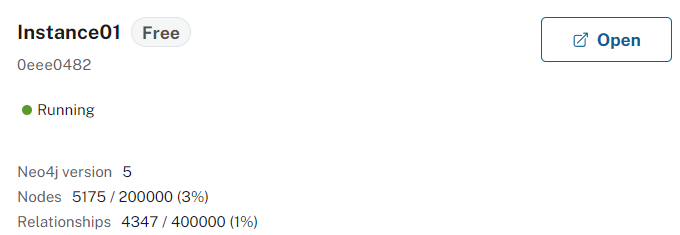

## Queries

### RAG

Iniciaremos com testes de recuperação + geração de resposta (LLM)

In [ ]:
query_engine = index.as_query_engine(
    include_text=False, response_mode="tree_summarize", # include_text =True send the text from where the retrieved tripets were extracted.
    embedding_mode="hybrid",
    similarity_top_k=5,
)


In [ ]:
inicio = time.time()
response_1 = query_engine.query("Como pagar a segunda via do IPTU")
fim = time.time()

tempo_decorrido = fim - inicio
print(f"Tempo de recuperação+geração: {tempo_decorrido} segundos")

Tempo de recuperação+geração: 2.6655800342559814 segundos


In [ ]:
response_1

Response(response='Para pagar a segunda via do IPTU, você pode solicitar diretamente no banco ou obtê-la no site da Nota Carioca. Além disso, o pagamento pode ser feito na maioria dos bancos.', source_nodes=[NodeWithScore(node=TextNode(id_='0ccd65dc-43be-4ef0-9c58-96aaffae970f', embedding=None, metadata={'kg_rel_texts': ["('Secretaria municipal de fazenda e planejamento', 'Enviou', 'Nova guia de pagamento do iptu 2022')", "('Nota carioca', 'Oferece', 'Crédito para abatimento no iptu')", "('Nota carioca', 'Gera crédito para', 'Abatimento no iptu')", "('Nota carioca', 'É', 'Crédito para abatimento no iptu')", "['DEVE_SER_SOLICITADO', 'Diretamente no banco']", "['PODE_SER_OBTIDA_NO', 'Site da nota carioca']", "('Pagamento do iptu', 'Tem', 'Desconto de 7%')", "['DEPENDE_DE', 'Características do imóvel']", "['PODE_SER_PAGO', 'Na maioria dos bancos']", "['PODE_VARIAR', 'Com base na decad']", "['PODE_SER_ABATIDO_EM', 'Até 100%']"], 'kg_rel_map': {'Segunda via': [['PODE_SER_OBTIDA_NO', 'Site d

Nós recuperados:

In [ ]:
kg_rel_texts = [node.node.metadata.get('kg_rel_texts', None) for node in response_1.source_nodes if node.node.metadata.get('kg_rel_texts', None) is not None]
kg_rel_map = [node.node.metadata.get('kg_rel_map', None) for node in response_1.source_nodes if node.node.metadata.get('kg_rel_map', None) is not None]
kg_rel_texts, kg_rel_map

([["('Secretaria municipal de fazenda e planejamento', 'Enviou', 'Nova guia de pagamento do iptu 2022')",
   "('Nota carioca', 'Oferece', 'Crédito para abatimento no iptu')",
   "('Nota carioca', 'Gera crédito para', 'Abatimento no iptu')",
   "('Nota carioca', 'É', 'Crédito para abatimento no iptu')",
   "['DEVE_SER_SOLICITADO', 'Diretamente no banco']",
   "['PODE_SER_OBTIDA_NO', 'Site da nota carioca']",
   "('Pagamento do iptu', 'Tem', 'Desconto de 7%')",
   "['DEPENDE_DE', 'Características do imóvel']",
   "['PODE_SER_PAGO', 'Na maioria dos bancos']",
   "['PODE_VARIAR', 'Com base na decad']",
   "['PODE_SER_ABATIDO_EM', 'Até 100%']"]],
 [{'Segunda via': [['PODE_SER_OBTIDA_NO', 'Site da nota carioca']],
   'Iptu': [['PODE_SER_PAGO', 'Na maioria dos bancos'],
    ['PODE_VARIAR', 'Com base na decad'],
    ['DEPENDE_DE', 'Características do imóvel'],
    ['PODE_SER_ABATIDO_EM', 'Até 100%'],
    ['DEVE_SER_SOLICITADO', 'Diretamente no banco']]}])

In [ ]:
display(Markdown(f"<b>{response_1}</b>")) # Output do LLM

<b>Para pagar a segunda via do IPTU, você pode solicitar diretamente no banco ou obtê-la no site da Nota Carioca. Além disso, o pagamento pode ser feito na maioria dos bancos.</b>

In [ ]:
inicio = time.time()
response_2 = query_engine.query("Como matricular minha filha na creche?")
fim = time.time()

tempo_decorrido = fim - inicio
print(f"Tempo de recuperação+geração: {tempo_decorrido} segundos")

Tempo de recuperação+geração: 3.9493372440338135 segundos


In [ ]:
response_2

Response(response='Para matricular sua filha na creche, você deve seguir alguns passos. Primeiro, verifique se sua filha tem entre 6 meses e 3 anos e 11 meses, pois essa é a faixa etária permitida para inscrição. Em seguida, procure informações sobre o período de inscrição da creche pública desejada, pois as matrículas são garantidas para crianças com deficiência. Após isso, você pode iniciar o processo de inscrição, que geralmente começa a partir do mês da inscrição. Certifique-se de ter todos os documentos necessários para completar a matrícula.', source_nodes=[NodeWithScore(node=TextNode(id_='e9818565-4e3b-4833-b604-0720b9c3dbfa', embedding=None, metadata={'kg_rel_texts': ["('Criança com deficiência', 'Tem matrícula garantida', 'Creche institucional dr. paulo niemeyer')", "('Crianças', 'Podem ser inscritas', '6 meses a 3 anos e 11 meses')", "('Previ-creche', 'Dá-se a partir do mês', 'Da inscrição')", "('Creche pública', 'Tem', 'Período de inscrição')", "('Educação infantil', 'Inclui

Nós recuperados:

In [ ]:
kg_rel_texts = [node.node.metadata.get('kg_rel_texts', None) for node in response_2.source_nodes if node.node.metadata.get('kg_rel_texts', None) is not None]
kg_rel_map = [node.node.metadata.get('kg_rel_map', None) for node in response_2.source_nodes if node.node.metadata.get('kg_rel_map', None) is not None]
kg_rel_texts, kg_rel_map

([["('Criança com deficiência', 'Tem matrícula garantida', 'Creche institucional dr. paulo niemeyer')",
   "('Crianças', 'Podem ser inscritas', '6 meses a 3 anos e 11 meses')",
   "('Previ-creche', 'Dá-se a partir do mês', 'Da inscrição')",
   "('Creche pública', 'Tem', 'Período de inscrição')",
   "('Educação infantil', 'Inclui', 'Creche')"]],
 [{}])

In [ ]:
display(Markdown(f"<b>{response_2}</b>")) # Output do LLM


<b>Para matricular sua filha na creche, você deve seguir alguns passos. Primeiro, verifique se sua filha tem entre 6 meses e 3 anos e 11 meses, pois essa é a faixa etária permitida para inscrição. Em seguida, procure informações sobre o período de inscrição da creche pública desejada, pois as matrículas são garantidas para crianças com deficiência. Após isso, você pode iniciar o processo de inscrição, que geralmente começa a partir do mês da inscrição. Certifique-se de ter todos os documentos necessários para completar a matrícula.</b>

### Recuperação

Agora faremos testes apenas de recuperação

In [ ]:
inicio = time.time()
retriever_response_1 = index.as_retriever(similarity_top_k=5, vector_store_query_mode="hybrid").retrieve("Como solicitar remoção de árvore caída?")
fim = time.time()
tempo_decorrido = fim - inicio
print(f"Tempo de recuperação: {tempo_decorrido} segundos")

Tempo de recuperação: 2.02494478225708 segundos


In [ ]:
retriever_response_1

[NodeWithScore(node=TextNode(id_='cd8021d8-3eaf-48fb-8f07-40040c6d48cd', embedding=None, metadata={'file_path': 'macall-dados-pcrj/documentos/Reclamação_Manejo Arbóreo_Avaliação de risco de queda da árvore.txt', 'file_name': 'Reclamação_Manejo Arbóreo_Avaliação de risco de queda da árvore.txt', 'file_type': 'text/plain', 'file_size': 813}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='s3_macall-dados-pcrj/documentos/Reclamação_Manejo Arbóreo_Avaliação de risco de queda da árvore.txt', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'file_path': 'macall-dados-pcrj/documentos/Reclamação_Manejo Arbóreo_Avaliação de risco de queda da árvore.txt', 'file_name': 'Reclamação_Manejo Arbóreo_Avaliação de risco de q

Nós recuperados:

In [ ]:
kg_rel_texts = [node.node.metadata.get('kg_rel_texts', None) for node in retriever_response_1 if node.node.metadata.get('kg_rel_texts', None) is not None]
kg_rel_map = [node.node.metadata.get('kg_rel_map', None) for node in retriever_response_1 if node.node.metadata.get('kg_rel_map', None) is not None]
kg_rel_texts, kg_rel_map

([["('Serviço', 'É', 'Vistoria e avaliação da necessidade de retirada de árvore')",
   "('Engenheiro florestal', 'Avalia', 'Necessidade de poda da árvore')",
   "('Serviço', 'É', 'Poda e remoção de árvores em áreas públicas')",
   "('Serviço', 'É', 'Poda e remoção de árvores')",
   "['É', 'Necessária após exumação definitiva']",
   "('Serviço', 'É', 'Retirada de árvore caída')",
   "['CAUSA', 'Dano ou morte do vegetal']"]],
 [{'Remoção': [['É', 'Necessária após exumação definitiva']],
   'Árvore': [['CAUSA', 'Dano ou morte do vegetal']]}])

In [ ]:
inicio = time.time()
retriever_response_2 = index.as_retriever(similarity_top_k=5, vector_store_query_mode="hybrid").retrieve("Como me ser beneficiado pelo bolsa-família?")
fim = time.time()
tempo_decorrido = fim - inicio
print(f"Tempo de recuperação: {tempo_decorrido} segundos")

Tempo de recuperação: 1.7258391380310059 segundos


In [ ]:
retriever_response_2

[NodeWithScore(node=TextNode(id_='277016bf-1dc0-4bbf-9e78-4619018ce6c8', embedding=None, metadata={'file_path': 'macall-dados-pcrj/documentos/Informações_Cadastro Único_Informações sobre o Programa Bolsa Família .txt', 'file_name': 'Informações_Cadastro Único_Informações sobre o Programa Bolsa Família .txt', 'file_type': 'text/plain', 'file_size': 4440}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='s3_macall-dados-pcrj/documentos/Informações_Cadastro Único_Informações sobre o Programa Bolsa Família .txt', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'file_path': 'macall-dados-pcrj/documentos/Informações_Cadastro Único_Informações sobre o Programa Bolsa Família .txt', 'file_name': 'Informações_Cadastro

Nós recuperados:

In [ ]:
kg_rel_texts = [node.node.metadata.get('kg_rel_texts', None) for node in retriever_response_2 if node.node.metadata.get('kg_rel_texts', None) is not None]
kg_rel_map = [node.node.metadata.get('kg_rel_map', None) for node in retriever_response_2 if node.node.metadata.get('kg_rel_map', None) is not None]
kg_rel_texts, kg_rel_map

([["('Auxílio natalidade', 'Será pago', 'Àquele que tem o dependente cadastrado no salário família')",
   "('Programa bolsa família', 'É', 'Maior programa de transferência de renda do brasil')",
   "('Programa bolsa família', 'Paga', 'Benefício extraordinário de transição')",
   "('Programa bolsa família', 'Oferece', 'Benefício de renda de cidadania')",
   "('Programa bolsa família', 'Oferece', 'Benefício complementar')",
   "['DEVE_OBSERVAR', 'Último dígito do nis']"]],
 [{'Família': [['DEVE_OBSERVAR', 'Último dígito do nis']]}])